In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

xds_est = db.Load_ESTELA_data()              # ESTELA D data
xds_WAVES = db.Load_ESTELA_waves()           # ESTELA gow waves point
xds_SLP_site = db.Load_ESTELA_SLP()          # ESTELA Sea Level Pressure
xds_wvs_pts = db.Load_WAVES_partitions()     # waves partitions data

_, xds_TCs_r1_params = db.Load_TCs_r1()      # TCs historical parameters inside 14º radius 

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-22'
kma_date_end = '2011-01-22'
num_clusters = 36
kmarg_alpha = 0.36



## ESTELA Predictor - Sea Level Pressure and Gradient

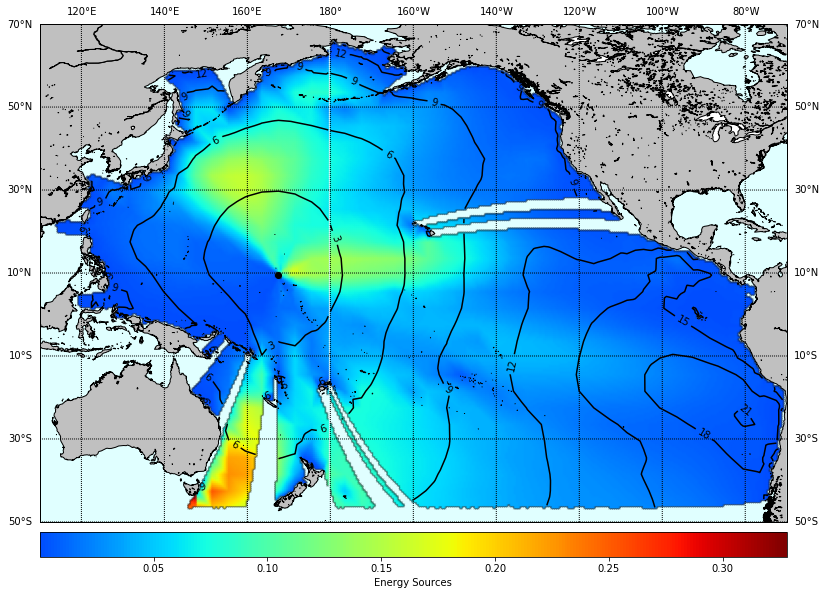

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = xds_est.mask_shadow

Plot_ESTELA(
    xds_est.pnt_longitude, xds_est.pnt_latitude,
    xds_est.F_y1993to2012 * mask_plot, 
    xds_est.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
)


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
hs = xds_WAVES.hs
tm = xds_WAVES.t02
Fe = np.multiply(hs**2,tm)**(1.0/3)
xds_WAVES.update({
    'Fe':(('time',), Fe)
})

# select time window and calculate daily mean
xds_WAVES = xds_WAVES.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

print(xds_WAVES)


<xarray.Dataset>
Dimensions:  (time: 11689)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
Data variables:
    fp       (time) float64 0.1037 0.09292 0.09458 ... 0.07067 0.06604 0.07121
    hs       (time) float64 3.105 2.933 2.88 2.24 ... 2.177 2.395 2.55 2.305
    t02      (time) float64 6.059 6.032 5.998 5.773 ... 6.9 8.265 7.428 6.794
    dir      (time) float64 58.25 55.27 58.52 55.72 ... 159.7 351.0 165.9 10.58
    spr      (time) float64 39.06 40.38 36.42 38.68 ... 47.4 41.82 39.79 42.83
    hsCal    (time) float64 3.191 2.935 2.898 2.101 ... 2.006 2.09 2.379 2.23
    Fe       (time) float64 3.879 3.729 3.677 3.07 ... 3.198 3.619 3.641 3.304


In [6]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
xds_SLP_day = xds_SLP_site.sel(
    time = slice(kma_date_ini, kma_date_end)
).resample(time='1D').mean()

# calculate daily gradients
xds_SLP_day = spatial_gradient(xds_SLP_day, 'SLP')

print(xds_SLP_day)
    

<xarray.Dataset>
Dimensions:       (latitude: 31, longitude: 83, time: 11689)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-22 1979-01-23 ... 2011-01-22
  * latitude      (latitude) float64 60.5 58.5 56.5 54.5 ... 6.5 4.5 2.5 0.5
  * longitude     (longitude) float64 115.0 117.0 119.0 ... 275.0 277.0 279.0
Data variables:
    SLP           (time, latitude, longitude) float64 1.019e+05 ... 1.009e+05
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [7]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
xds_est_site = xds_est.sel(
    longitude = xds_SLP_site.longitude,
    latitude = xds_SLP_site.latitude,
)

estela_D = xds_est_site.D_y1993to2012
estela_mask = xds_est_site.mask_land  # ESTELA mask  TODO: mask_shadow // mask_land

# apply ESTELA mask to SLP data
xds_SLP_day['SLP'] = xds_SLP_day.SLP * estela_mask
xds_SLP_day['SLP_gradient'] = xds_SLP_day.SLP_gradient * estela_mask


# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = xds_SLP_day

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 3594, n_features: 3594, n_lat: 31, n_lon: 83, n_points: 5146, time: 11668)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 6.459 -8.461 ... -1.144e-15
    EOFs           (n_components, n_features) float64 0.0359 0.03646 ... 0.0 1.0
    variance       (n_components) float64 420.7 228.8 ... 2.474e-30 2.474e-30
    pred_mean      (n_features) float64 1.012e+05 1.013e+05 ... 0.0 0.0
    pred_std       (n_features) float64 553.4 619.2 536.6 429.2 ... 0.0 0.0 0.0
    pred_lon       (n_lon) float64 115.0 117.0 119.0 121.0 ... 275.0 277.0 279.0
    pred_lat       (n_lat) float64 60.5 58.5 56.5 54.5 52.5 ... 6.5 4.5 2.5 0.5
    pred_time      (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2011-01-22
    pred_data_pos  (n_points) bool False False False False ... True True True
Attributes:
    method:     gradient + estela
    pred_name:  SLP


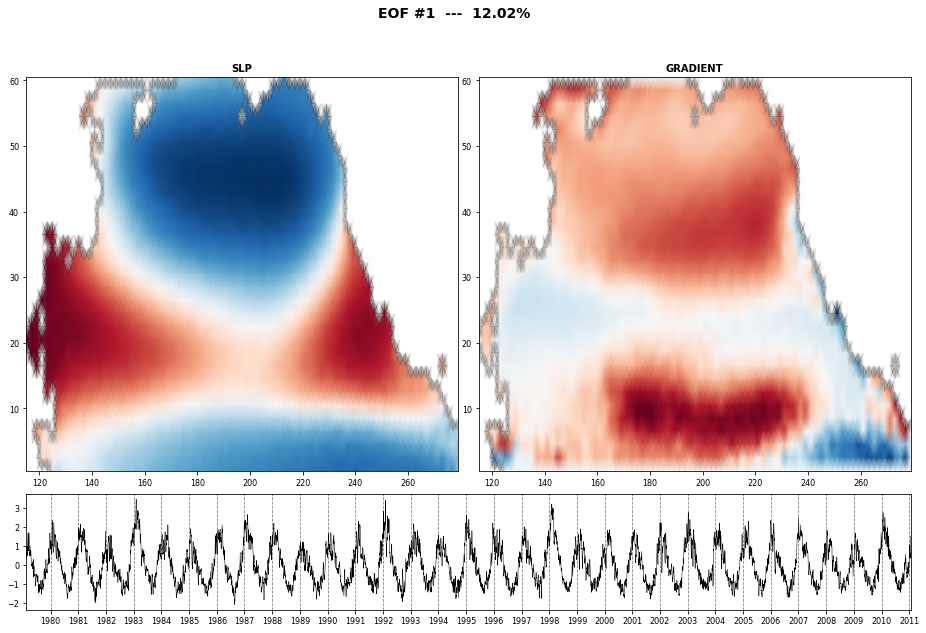

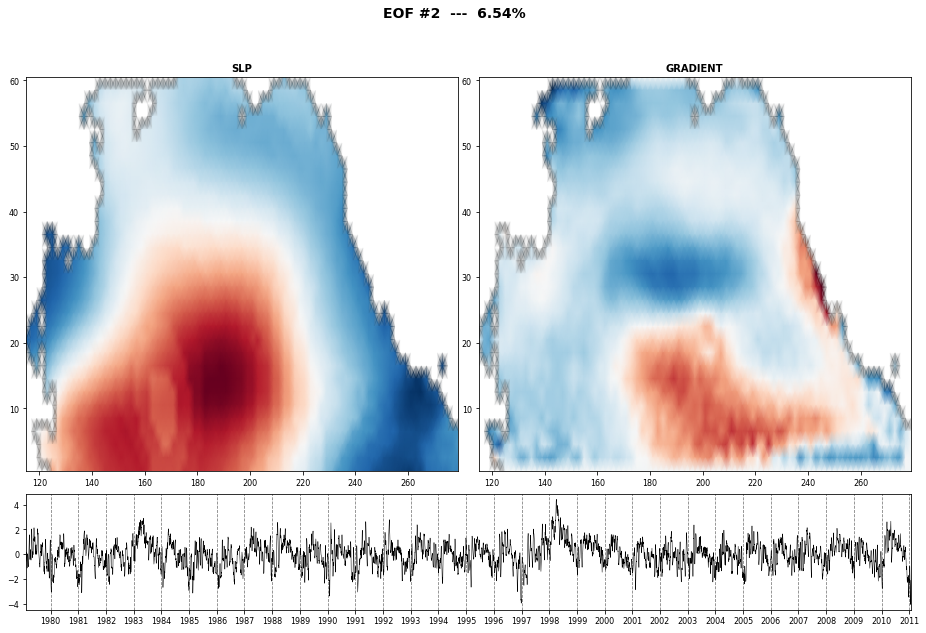

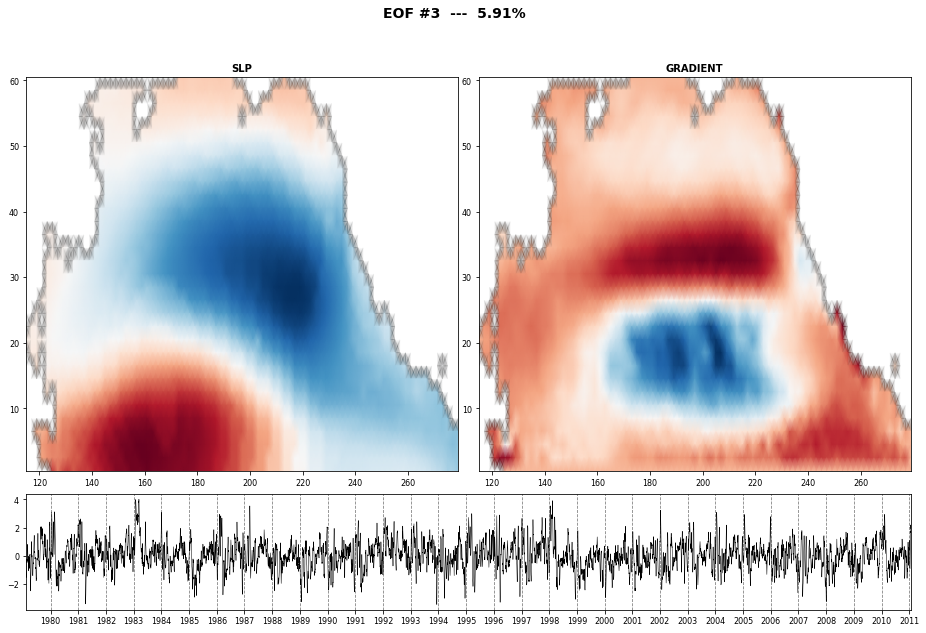

In [8]:
# plot PCA EOFs
n_EOFs = 3
pred.Plot_EOFs_EstelaPred(n_EOFs, show=True)



## ESTELA Predictor - KMeans Classification

In [9]:
# Calculate KMA (regression guided with WAVES data)

# TODO: encontrar alpha optimo?
pred.Calc_KMA_regressionguided(
    num_clusters,
    xds_WAVES, ['hs','t02','Fe'],
    kmarg_alpha)

print(pred.KMA)


<xarray.Dataset>
Dimensions:           (n_clusters: 36, n_components: 11668, n_features: 432)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus              (n_components) int32 17 17 26 26 4 4 ... 18 18 18 18 18 18
    cenEOFs           (n_clusters, n_features) float64 -0.4192 ... -0.3559
    centroids         (n_clusters, n_features) float64 -13.43 -4.54 ... 2.091
    group_size        (n_clusters) int64 81 618 136 121 331 ... 441 202 44 777
    sorted_order      (n_clusters) int64 33 28 2 4 29 15 23 ... 5 8 3 1 12 16 34
    sorted_bmus       (n_components) int64 13 13 20 20 3 3 3 ... 15 8 8 8 8 8 8
    sorted_cenEOFs    (n_clusters, n_features) float64 1.107 -0.178 ... -0.2919
    sorted_centroids  (n_clusters, n_features) float64 35.47 -5.704 ... 2.187
    time              (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
Attributes:
    method:   regression guided
    alpha:    0.36


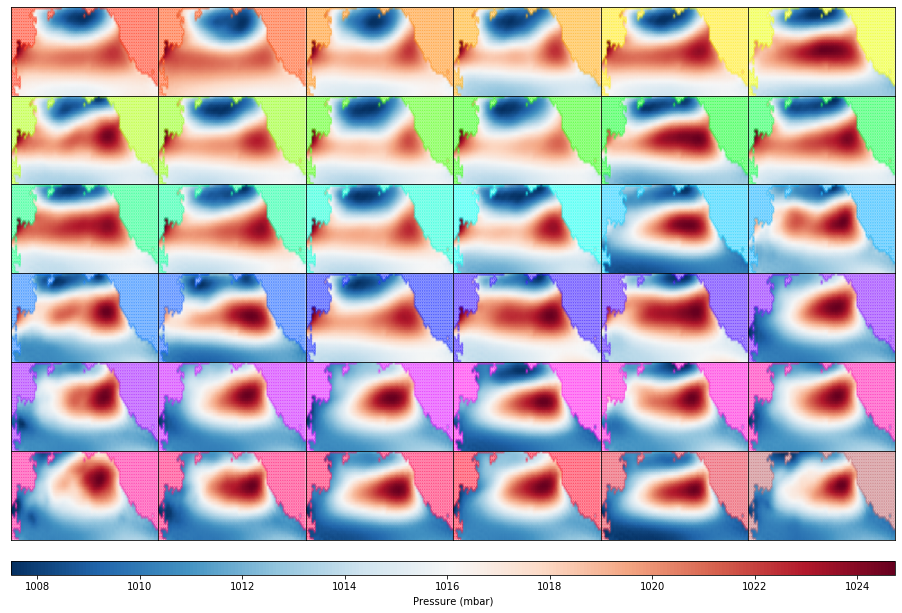

In [10]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', show=True)


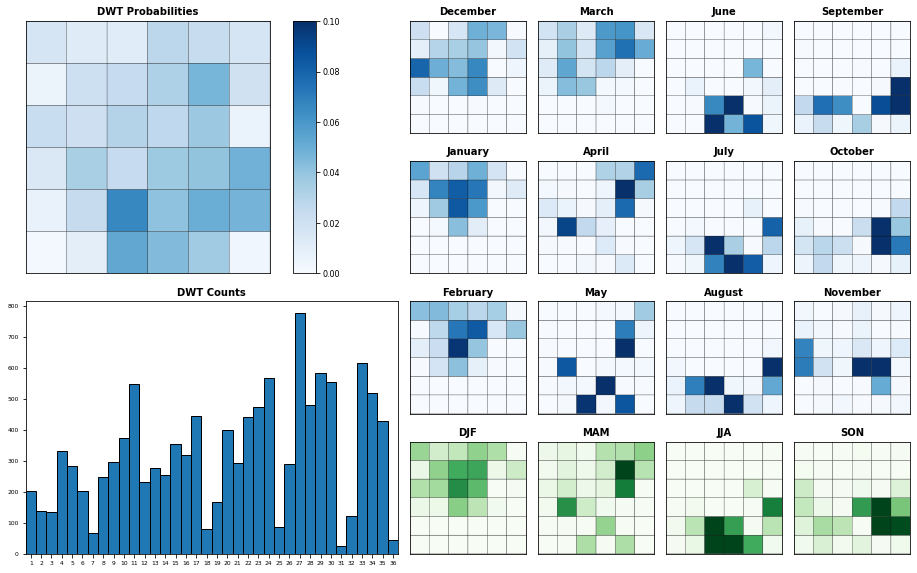

In [4]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs()


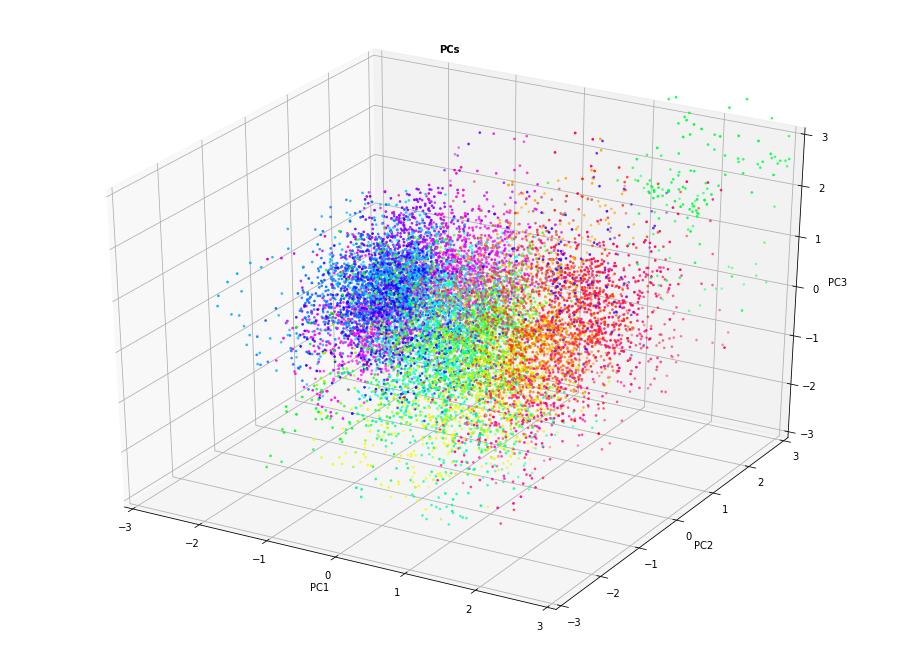

In [12]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D()


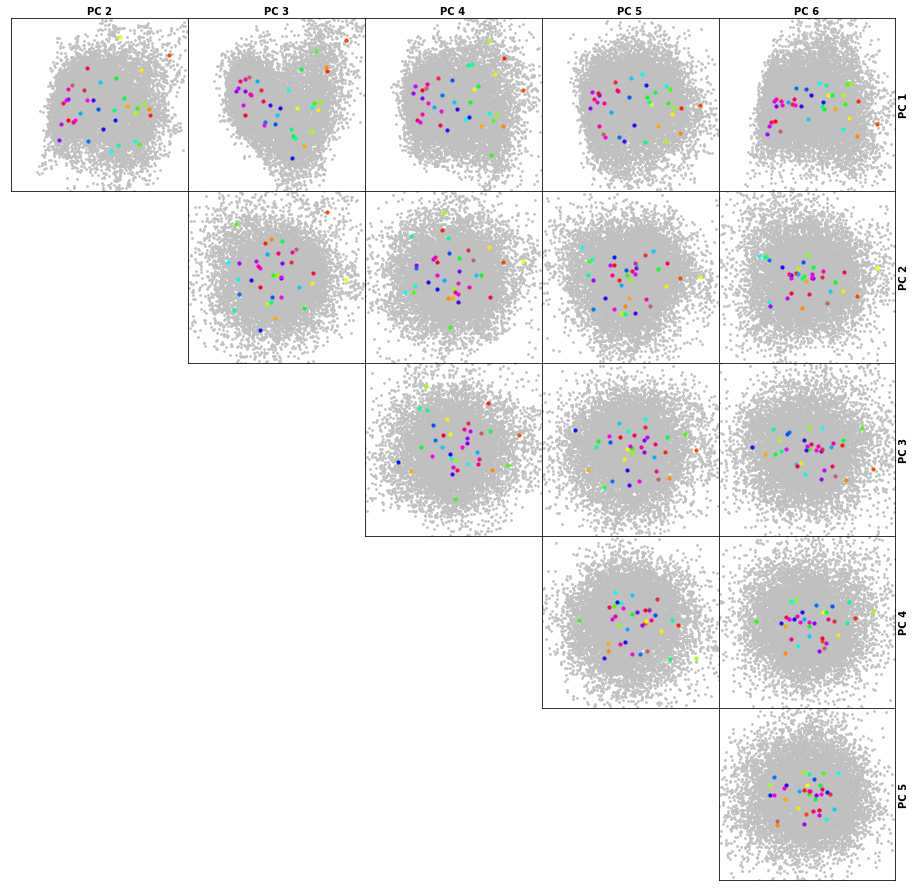

In [13]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6)



## ESTELA Predictor - Add Historical TCs

In [14]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = xds_TCs_r1_params.dmin_date.values[:]
storm_categs = xds_TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)


<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 11668, n_features: 432)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 17 17 26 26 4 4 ... 18 18 18 18 18
    cenEOFs             (n_clusters, n_features) float64 -0.4192 ... -0.3559
    centroids           (n_clusters, n_features) float64 -13.43 -4.54 ... 2.091
    group_size          (n_clusters) int64 81 618 136 121 331 ... 441 202 44 777
    sorted_order        (n_clusters) int64 33 28 2 4 29 15 23 ... 8 3 1 12 16 34
    sorted_bmus         (n_components) int64 13 13 20 20 3 3 3 ... 8 8 8 8 8 8
    sorted_cenEOFs      (n_clusters, n_features) float64 1.107 ... -0.2919
    sorted_centroids    (n_clusters, n_features) float64 35.47 -5.704 ... 2.187
    time                (n_components) datetime64[ns] 1979-02-12 ... 2011-01-22
    sorted_bmus_storms  (n_components) int64 13 13 20 20 3 3 3 ... 8 8 8 8 8 8
Attributes:
    method:   r

In [15]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_xds_MUTAU = pred.Calc_MU_TAU_Hydrographs(xds_wvs_pts)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_xds_MUTAU)

# TODO: plot report hydrographs

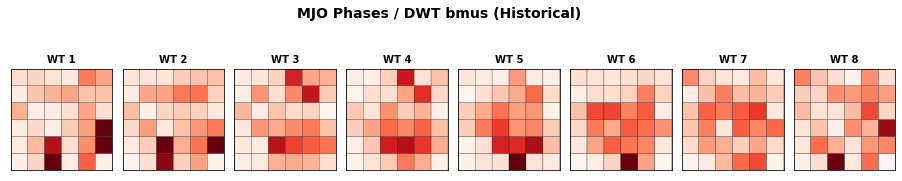

In [16]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
xds_MJO_hist, xds_DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = xds_MJO_hist.phase.values[:]
DWT_bmus = xds_DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='MJO Phases / DWT bmus (Historical)')
